
# Lab | Clustering songs

## Introduction

Now it's time to cluster the songs of the **hot_songs** and **not_hot_songs** databases according to the song's audio features. For this purpose, you need to consider the following questions:

* Are you going to use all the audio features? I
  * If not, which ones do you think that makes more sense to be used?
  * It might make sense to use a dimensionality reduction technique to visualize the songs with only two features?
* What is the optimal number of clusters (for methods that need to know this beforehand)?
* What is the best distance to use?
* What clustering method provides better results?
* Does the clustering method need a transformer?

## Considerations

Be aware that this process is extremely time-consuming!!! (it might take several hours on your laptop). Therefore, when testing different options, save the models into your disk in order to be able to use the best model later.  You don't want to retrain the best model again when you know what are the optimal parameters for each.

To determine which clustering method performs best, you need to be practical and think about how many clusters you might want to have alongside with a [clustering metric](https://analyticsindiamag.com/a-tutorial-on-various-clustering-evaluation-metrics/) to evaluate how good or bad the songs were clustered.
If the number of clusters is small, each cluster will be too big and generic. On the contrary, if the number of clusters is too big then each cluster will be too specific and it will be poorly populated (this also depends on how heterogeneous is your dataset).

On the other hand, when you train your clustering model make sure to concatenate both databases together (ie: **hot_songs** and **not_hot_songs**) before. 
If you don't combine both datasets, the clusters obtained with the **hot_songs** will be different than the ones obtained with the **not_hot_songs**
database even though they might have the same label because they will contain different songs. However, after this, you will not know to which original
dataframe belongs each song. To prevent this problem, before the concatenation you can add a new column named "dataset" with a "flag" to remind yourself in which dataset was included ("Hot", "Not hot")
each song. 

Finally, add a new column to the full dataset **for each clustering method with the cluster membership of each song** 


In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Spotify API credentials
client_id = 'd7ecba8b249c437fa94175cbe74c5cad'
client_secret = '3ebaecf089cf4e81af1bd8172ee05b85'

# Initialize Spotipy with client credentials
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [3]:
hot_songs_feat = pd.read_csv('hot_songs_with_feat.csv')
not_hot_songs_feat = pd.read_csv('not_hot_songs_with_feat.csv')

In [4]:
hot_songs_feat["hot_song"]=pd.Series(1, index=hot_songs_feat.index)
hot_songs_feat.head()

,Title,Artists,id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,hot_song
0,Rockin' Around The Christmas Tree,Brenda Lee,2EjXfH91m7f8HiJN1yQg97,0.589,0.472,8,-8.749,1,0.0502,0.61400,...,0.5050,0.898,67.196,audio_features,spotify:track:2EjXfH91m7f8HiJN1yQg97,https://api.spotify.com/v1/tracks/2EjXfH91m7f8...,https://api.spotify.com/v1/audio-analysis/2EjX...,126267,4,1
1,All I Want For Christmas Is You,Mariah Carey,7iKRL1F3m4t4dkMponnD0P,0.548,0.871,7,-4.253,1,0.0708,0.00113,...,0.7650,0.640,128.136,audio_features,spotify:track:7iKRL1F3m4t4dkMponnD0P,https://api.spotify.com/v1/tracks/7iKRL1F3m4t4...,https://api.spotify.com/v1/audio-analysis/7iKR...,215653,4,1
2,Jingle Bell Rock,Bobby Helms,7vQbuQcyTflfCIOu3Uzzya,0.754,0.424,2,-8.463,1,0.0363,0.64300,...,0.0652,0.806,119.705,audio_features,spotify:track:7vQbuQcyTflfCIOu3Uzzya,https://api.spotify.com/v1/tracks/7vQbuQcyTflf...,https://api.spotify.com/v1/audio-analysis/7vQb...,130973,4,1
3,Last Christmas,Wham!,2FRnf9qhLbvw8fu4IBXx78,0.735,0.478,2,-12.472,1,0.0293,0.18900,...,0.3550,0.947,107.682,audio_features,spotify:track:2FRnf9qhLbvw8fu4IBXx78,https://api.spotify.com/v1/tracks/2FRnf9qhLbvw...,https://api.spotify.com/v1/audio-analysis/2FRn...,262960,4,1
4,A Holly Jolly Christmas,Burl Ives,77khP2fIVhSW23NwxrRluh,0.683,0.375,0,-13.056,1,0.0303,0.57900,...,0.0760,0.888,140.467,audio_features,spotify:track:77khP2fIVhSW23NwxrRluh,https://api.spotify.com/v1/tracks/77khP2fIVhSW...,https://api.spotify.com/v1/audio-analysis/77kh...,135533,4,1


In [5]:
not_hot_songs_feat["hot_song"]=pd.Series(0, index=not_hot_songs_feat.index)
not_hot_songs_feat.head()

,Artists,Title,id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,hot_song
0,Sam Feldt,Post Malone,36orMWv2PgvnzXsd5CJ0yL,0.590,0.642,7,-3.870,1,0.1220,0.0771,...,0.1050,0.651,107.356,audio_features,spotify:track:36orMWv2PgvnzXsd5CJ0yL,https://api.spotify.com/v1/tracks/36orMWv2Pgvn...,https://api.spotify.com/v1/audio-analysis/36or...,174444,4,0
1,Quality Control,100 Racks (Offset feat. Playboi Carti),4T2dHb8XBYHlVj7Dyo1cW9,0.939,0.632,1,-2.978,1,0.1370,0.0606,...,0.1010,0.364,133.979,audio_features,spotify:track:4T2dHb8XBYHlVj7Dyo1cW9,https://api.spotify.com/v1/tracks/4T2dHb8XBYHl...,https://api.spotify.com/v1/audio-analysis/4T2d...,157645,4,0
2,Drake,God's Plan,6DCZcSspjsKoFjzjrWoCdn,0.754,0.449,7,-9.211,1,0.1090,0.0332,...,0.5520,0.357,77.169,audio_features,spotify:track:6DCZcSspjsKoFjzjrWoCdn,https://api.spotify.com/v1/tracks/6DCZcSspjsKo...,https://api.spotify.com/v1/audio-analysis/6DCZ...,198973,4,0
3,Francis and the Lights,May I Have This Dance (Remix),0VaIsQoIQY10uxBrOyZ5cQ,0.784,0.435,8,-9.197,1,0.0647,0.4640,...,0.0913,0.865,90.033,audio_features,spotify:track:0VaIsQoIQY10uxBrOyZ5cQ,https://api.spotify.com/v1/tracks/0VaIsQoIQY10...,https://api.spotify.com/v1/audio-analysis/0VaI...,195356,4,0
4,Future,Trapped In The Sun,6QeUzTuBoasiii8nevDciq,0.701,0.546,6,-5.918,0,0.1330,0.4350,...,0.1880,0.118,151.900,audio_features,spotify:track:6QeUzTuBoasiii8nevDciq,https://api.spotify.com/v1/tracks/6QeUzTuBoasi...,https://api.spotify.com/v1/audio-analysis/6QeU...,201980,4,0


In [6]:
combined_data=pd.concat([hot_songs_feat,not_hot_songs_feat],ignore_index=True)
combined_data.head()

,Title,Artists,id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,hot_song
0,Rockin' Around The Christmas Tree,Brenda Lee,2EjXfH91m7f8HiJN1yQg97,0.589,0.472,8,-8.749,1,0.0502,0.61400,...,0.5050,0.898,67.196,audio_features,spotify:track:2EjXfH91m7f8HiJN1yQg97,https://api.spotify.com/v1/tracks/2EjXfH91m7f8...,https://api.spotify.com/v1/audio-analysis/2EjX...,126267,4,1
1,All I Want For Christmas Is You,Mariah Carey,7iKRL1F3m4t4dkMponnD0P,0.548,0.871,7,-4.253,1,0.0708,0.00113,...,0.7650,0.640,128.136,audio_features,spotify:track:7iKRL1F3m4t4dkMponnD0P,https://api.spotify.com/v1/tracks/7iKRL1F3m4t4...,https://api.spotify.com/v1/audio-analysis/7iKR...,215653,4,1
2,Jingle Bell Rock,Bobby Helms,7vQbuQcyTflfCIOu3Uzzya,0.754,0.424,2,-8.463,1,0.0363,0.64300,...,0.0652,0.806,119.705,audio_features,spotify:track:7vQbuQcyTflfCIOu3Uzzya,https://api.spotify.com/v1/tracks/7vQbuQcyTflf...,https://api.spotify.com/v1/audio-analysis/7vQb...,130973,4,1
3,Last Christmas,Wham!,2FRnf9qhLbvw8fu4IBXx78,0.735,0.478,2,-12.472,1,0.0293,0.18900,...,0.3550,0.947,107.682,audio_features,spotify:track:2FRnf9qhLbvw8fu4IBXx78,https://api.spotify.com/v1/tracks/2FRnf9qhLbvw...,https://api.spotify.com/v1/audio-analysis/2FRn...,262960,4,1
4,A Holly Jolly Christmas,Burl Ives,77khP2fIVhSW23NwxrRluh,0.683,0.375,0,-13.056,1,0.0303,0.57900,...,0.0760,0.888,140.467,audio_features,spotify:track:77khP2fIVhSW23NwxrRluh,https://api.spotify.com/v1/tracks/77khP2fIVhSW...,https://api.spotify.com/v1/audio-analysis/77kh...,135533,4,1


In [7]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590 entries, 0 to 2589
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2590 non-null   object 
 1   Artists           2590 non-null   object 
 2   id                2590 non-null   object 
 3   danceability      2590 non-null   float64
 4   energy            2590 non-null   float64
 5   key               2590 non-null   int64  
 6   loudness          2590 non-null   float64
 7   mode              2590 non-null   int64  
 8   speechiness       2590 non-null   float64
 9   acousticness      2590 non-null   float64
 10  instrumentalness  2590 non-null   float64
 11  liveness          2590 non-null   float64
 12  valence           2590 non-null   float64
 13  tempo             2590 non-null   float64
 14  type              2590 non-null   object 
 15  uri               2590 non-null   object 
 16  track_href        2590 non-null   object 


In [8]:
features=combined_data.select_dtypes(exclude=[object])
features.drop('hot_song', axis=1, inplace=True)

In [9]:
features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.589,0.472,8,-8.749,1,0.0502,0.61400,0.000000,0.5050,0.898,67.196,126267,4
1,0.548,0.871,7,-4.253,1,0.0708,0.00113,0.000000,0.7650,0.640,128.136,215653,4
2,0.754,0.424,2,-8.463,1,0.0363,0.64300,0.000000,0.0652,0.806,119.705,130973,4
3,0.735,0.478,2,-12.472,1,0.0293,0.18900,0.000002,0.3550,0.947,107.682,262960,4
4,0.683,0.375,0,-13.056,1,0.0303,0.57900,0.000000,0.0760,0.888,140.467,135533,4


In [10]:
columns_to_drop = ['liveness', 'duration_ms', 'time_signature']
features.drop(columns=columns_to_drop, inplace=True)

In [11]:
features.shape

(2590, 10)

In [12]:
from sklearn.preprocessing import StandardScaler
features.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
count,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000
mean,0.652459,0.623041,5.091506,-6.932478,0.604247,0.138012,0.229500,0.019191,0.466081,121.976825
std,0.155780,0.180596,3.652294,2.912992,0.489106,0.128914,0.259990,0.103879,0.224355,29.739634
min,0.074600,0.006320,0.000000,-31.160000,0.000000,0.024700,0.000008,0.000000,0.026200,40.319000
25%,0.550250,0.514000,1.000000,-8.209000,0.000000,0.042800,0.030100,0.000000,0.288250,96.494500
50%,0.661500,0.637500,5.000000,-6.493000,1.000000,0.077200,0.123500,0.000000,0.458000,123.031500
75%,0.768000,0.756750,8.000000,-4.959750,1.000000,0.207750,0.341750,0.000051,0.635000,143.968250
max,0.980000,0.996000,11.000000,0.347000,1.000000,0.920000,0.995000,0.964000,0.981000,205.945000


In [13]:
import pickle

scaler = StandardScaler()
scaler.fit(features)
X_scaled = scaler.transform(features)
filename = "feature_scaler.pickle" # Path with filename

with open(filename, "wb") as file:
        pickle.dump(scaler,file)

X_scaled_df = pd.DataFrame(X_scaled, columns = features.columns)
display(features.head())
print()
display(X_scaled_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
0,0.589,0.472,8,-8.749,1,0.0502,0.61400,0.000000,0.898,67.196
1,0.548,0.871,7,-4.253,1,0.0708,0.00113,0.000000,0.640,128.136
2,0.754,0.424,2,-8.463,1,0.0363,0.64300,0.000000,0.806,119.705
3,0.735,0.478,2,-12.472,1,0.0293,0.18900,0.000002,0.947,107.682
4,0.683,0.375,0,-13.056,1,0.0303,0.57900,0.000000,0.888,140.467


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
0,-0.407441,-0.836509,0.796501,-0.623714,0.809291,-0.681300,1.479188,-0.184779,1.925533,-1.842370
1,-0.670683,1.373271,0.522648,0.920015,0.809291,-0.521473,-0.878551,-0.184779,0.775347,0.207143
2,0.651949,-1.102347,-0.846619,-0.525514,0.809291,-0.789145,1.590752,-0.184779,1.515389,-0.076405
3,0.529959,-0.803279,-0.846619,-1.902028,0.809291,-0.843456,-0.155807,-0.184755,2.143979,-0.480759
4,0.196090,-1.373724,-1.394326,-2.102548,0.809291,-0.835697,1.344541,-0.184779,1.880952,0.621855


In [14]:
X_scaled_df.shape

(2590, 10)

In [15]:
# computing PCA to find out if this dimensionality reduction method can be applied to model later.

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled_df)
principal_components = pca.transform(X_scaled_df)
principal_components_df = pd.DataFrame(principal_components, 
                                       columns=['PCA_'+ str(i) for i in range(1,X_scaled_df.shape[1]+1)])
principal_components_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,1.218014,0.068704,-0.265196,-2.739599,1.508222,-0.429998,-0.668810,0.388727,0.145342,-0.435053
1,-1.702691,-1.237677,-0.441476,-0.178787,0.338673,-0.606331,-0.733811,0.232126,0.311392,0.051964
2,1.101943,-0.182246,1.295632,-1.502865,1.524487,-0.435557,0.898944,-0.311104,-0.303388,-0.286803
3,0.761456,-0.148518,1.284405,-1.562812,1.677271,0.178991,0.505575,-0.435590,1.873321,0.138705
4,1.924628,-0.289574,1.734374,-0.998830,2.006428,-0.673621,1.409603,-0.144658,1.048015,0.175666


In [16]:
print(pca.explained_variance_ratio_)

[0.25752271 0.1296812  0.11693972 0.10575414 0.0926355  0.09003496
 0.07579357 0.07140848 0.04161688 0.01861283]


In [17]:
cumulated_explained_variance_ratio = [sum(pca.explained_variance_ratio_[0:i+1]) for i,value in enumerate(pca.explained_variance_ratio_)]
cumulated_explained_variance_ratio

[0.25752270822367895,
 0.3872039045415937,
 0.5041436226605076,
 0.6098977653992911,
 0.70253326154798,
 0.7925682259233421,
 0.8683618007059093,
 0.9397702855079528,
 0.981387165132382,
 1.0000000000000002]

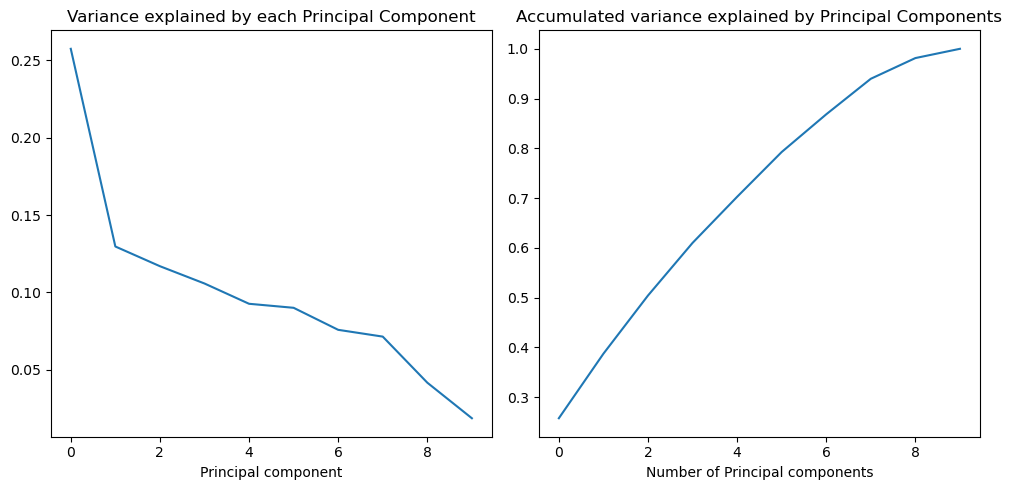

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(pca.explained_variance_ratio_)
ax[0].set_xlabel("Principal component")
ax[0].set_title("Variance explained by each Principal Component")
ax[1].plot(cumulated_explained_variance_ratio)
ax[1].set_title("Accumulated variance explained by Principal Components")
ax[1].set_xlabel("Number of Principal components")
plt.tight_layout()
plt.show()

The PCA look pretty grim... we'd have to use 7 columns to explain 80% of the data

##### Trying ISOMAP:

In [19]:
from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=12, n_components=2)
iso.fit(features)
X_isomap_transformed = iso.transform(features)
X_isomap_transformed_df = pd.DataFrame(X_isomap_transformed, columns=["ISO_1","ISO_2"])
X_isomap_transformed_df.head()

,ISO_1,ISO_2
0,-61.046088,0.995589
1,7.564637,-3.056384
2,-2.460613,3.817904
3,-16.760730,4.512814
4,20.801687,6.494922


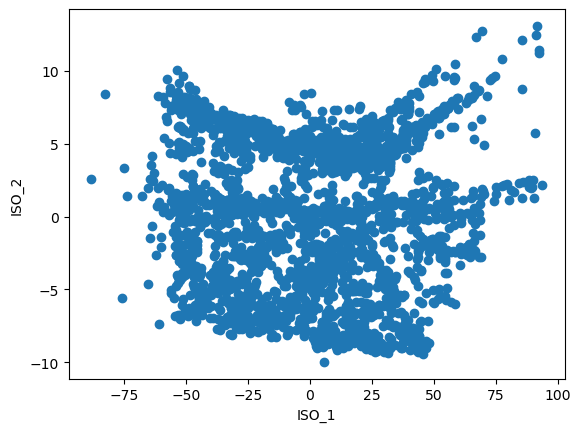

In [20]:
fig, ax = plt.subplots()
ax.scatter(X_isomap_transformed_df['ISO_1'],X_isomap_transformed_df['ISO_2'])
ax.set_xlabel("ISO_1")
ax.set_ylabel("ISO_2")
plt.show()

##### Trying UMAP:

In [21]:
from umap import UMAP

reducer = UMAP(n_components=2,random_state=42)
reducer.fit(features)

umap_filename = "umap.pickle" # Path with filename # kmeans_n.pickle
with open(umap_filename, "wb") as file:
    pickle.dump(reducer,file)

X_umap_transformed = reducer.transform(features)
X_umap_transformed_df = pd.DataFrame(X_umap_transformed, columns=["UMAP_1","UMAP_2"])
X_umap_transformed_df.head()

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,UMAP_1,UMAP_2
0,-3.156207,11.865191
1,7.525872,-4.274052
2,3.637302,-2.566351
3,0.853498,-1.259137
4,9.751296,0.061032


In [22]:
display(features)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
0,0.589,0.472,8,-8.749,1,0.0502,0.61400,0.000000,0.898,67.196
1,0.548,0.871,7,-4.253,1,0.0708,0.00113,0.000000,0.640,128.136
2,0.754,0.424,2,-8.463,1,0.0363,0.64300,0.000000,0.806,119.705
3,0.735,0.478,2,-12.472,1,0.0293,0.18900,0.000002,0.947,107.682
4,0.683,0.375,0,-13.056,1,0.0303,0.57900,0.000000,0.888,140.467
...,...,...,...,...,...,...,...,...,...,...
2585,0.830,0.644,10,-5.431,0,0.4070,0.02980,0.000000,0.227,155.103
2586,0.789,0.720,8,-5.652,0,0.2180,0.22300,0.000000,0.664,122.031
2587,0.665,0.539,1,-6.613,1,0.0699,0.16500,0.000000,0.666,145.828
2588,0.681,0.664,6,-8.019,0,0.0353,0.33500,0.000000,0.861,102.166


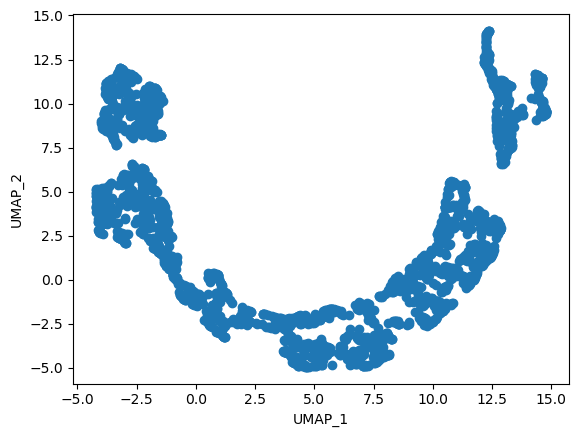

In [23]:
fig, ax = plt.subplots()
ax.scatter(X_umap_transformed_df['UMAP_1'],X_umap_transformed_df['UMAP_2'])
ax.set_xlabel("UMAP_1")
ax.set_ylabel("UMAP_2")
plt.show()

This dimensionality reduction method looks the best so far

### K-Means with scaled data (no dimensionality reduction)

In [24]:
# K-Means with 11 clusters

kmeans = KMeans(n_clusters=11, random_state=1234)
kmeans.fit(X_scaled_df)

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=11, random_state=1234)

In [25]:
clusters = kmeans.predict(X_scaled_df)
pd.Series(clusters).value_counts().sort_index() 

# number of songs in each cluster:

0     236
1     172
2     294
3     371
4     216
5     188
6     352
7     171
8      46
9     276
10    268
Name: count, dtype: int64

In [26]:
kmeans.inertia_

12654.379011147723

#### Checking the right K with non dimensionally reduced data 

Training a K-Means model with 2 clusters! 

Initialization complete
Iteration 0, inertia 40809.071893452536.
Iteration 1, inertia 23892.45875125802.
Iteration 2, inertia 23738.50769004693.
Iteration 3, inertia 23507.711271728665.
Iteration 4, inertia 23184.532254053098.
Iteration 5, inertia 22910.37784702248.
Iteration 6, inertia 22537.028394484994.
Iteration 7, inertia 22202.451956835695.
Iteration 8, inertia 21980.649014333394.
Iteration 9, inertia 21829.2844682899.
Iteration 10, inertia 21730.329712371728.
Iteration 11, inertia 21660.20967877248.
Iteration 12, inertia 21619.630449934488.
Iteration 13, inertia 21601.92099741186.
Iteration 14, inertia 21597.621604814572.
Iteration 15, inertia 21596.371768357574.
Iteration 16, inertia 21595.958535598525.
Iteration 17, inertia 21595.717126094823.
Iteration 18, inertia 21595.6407896795.
Converged at iteration 18: center shift 9.057229441540091e-05 within tolerance 9.999999999999954e-05.
Initialization complete
Iteration 0, inertia 31375.

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 40874.51844398626.
Iteration 1, inertia 21950.067592788957.
Iteration 2, inertia 21651.004522667503.
Iteration 3, inertia 21615.24823632252.
Iteration 4, inertia 21602.757539928396.
Iteration 5, inertia 21598.313157272496.
Iteration 6, inertia 21597.229777326895.
Iteration 7, inertia 21596.50544895747.
Iteration 8, inertia 21596.08656397702.
Iteration 9, inertia 21595.964845999093.
Converged at iteration 9: center shift 2.3055728887646954e-05 within tolerance 9.999999999999954e-05.
Training a K-Means model with 3 clusters! 

Initialization complete
Iteration 0, inertia 33309.90799190366.
Iteration 1, inertia 22225.61444932147.
Iteration 2, inertia 21960.919994091222.
Iteration 3, inertia 21691.391105511022.
Iteration 4, inertia 21589.357949273966.
Iteration 5, inertia 21580.966098444125.
Iteration 6, inertia 21576.345485388527.
Iteration 7, inertia 21571.686952151424.
Iteration 8, inertia 21564.469715843064.
Iteration 9, inertia 21552.405810999117.
Iteration 10, in

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 17, inertia 20427.614198504285.
Iteration 18, inertia 20107.007649388303.
Iteration 19, inertia 19913.56637048359.
Iteration 20, inertia 19834.743778639648.
Iteration 21, inertia 19800.90356847825.
Iteration 22, inertia 19786.449768039893.
Iteration 23, inertia 19774.714781268973.
Iteration 24, inertia 19764.9392065012.
Iteration 25, inertia 19759.63312854033.
Iteration 26, inertia 19754.72431598079.
Iteration 27, inertia 19751.028730349874.
Iteration 28, inertia 19748.18641791535.
Iteration 29, inertia 19743.63932152572.
Iteration 30, inertia 19737.544007862467.
Iteration 31, inertia 19715.982815409.
Iteration 32, inertia 19646.399824548214.
Iteration 33, inertia 19452.16667320367.
Iteration 34, inertia 19342.87919931377.
Iteration 35, inertia 19338.869080852026.
Iteration 36, inertia 19336.988042523313.
Iteration 37, inertia 19335.26781779738.
Iteration 38, inertia 19334.754838496723.
Converged at iteration 38: center shift 3.8488637258350637e-05 within tolerance 9.99999999

Iteration 16, inertia 19761.64172931872.
Iteration 17, inertia 19758.32778687709.
Iteration 18, inertia 19753.529670532043.
Iteration 19, inertia 19750.3450861629.
Iteration 20, inertia 19747.295096249898.
Iteration 21, inertia 19744.32398445536.
Iteration 22, inertia 19740.129639637104.
Iteration 23, inertia 19734.108571975354.
Iteration 24, inertia 19729.38939328273.
Iteration 25, inertia 19727.19646521823.
Iteration 26, inertia 19726.449239275993.
Iteration 27, inertia 19725.91695685627.
Iteration 28, inertia 19725.718268169185.
Converged at iteration 28: center shift 7.50777714607499e-05 within tolerance 9.999999999999954e-05.
Initialization complete
Iteration 0, inertia 32783.476040865775.
Iteration 1, inertia 22246.457206417632.
Iteration 2, inertia 21498.270679987963.
Iteration 3, inertia 20617.659631968076.
Iteration 4, inertia 20128.412346413905.
Iteration 5, inertia 19942.807950295806.
Iteration 6, inertia 19887.360479973075.
Iteration 7, inertia 19864.96210561248.
Iteration 

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 28877.446909780683.
Iteration 1, inertia 19512.31259087308.
Iteration 2, inertia 18999.651360056003.
Iteration 3, inertia 18794.824872765817.
Iteration 4, inertia 18707.14793713973.
Iteration 5, inertia 18651.10052449526.
Iteration 6, inertia 18620.391617277517.
Iteration 7, inertia 18603.339193360807.
Iteration 8, inertia 18588.94392230166.
Iteration 9, inertia 18574.59310328861.
Iteration 10, inertia 18552.816963650643.
Iteration 11, inertia 18534.11146466025.
Iteration 12, inertia 18515.141014266253.
Iteration 13, inertia 18497.331826132686.
Iteration 14, inertia 18479.9840119238.
Iteration 15, inertia 18468.86200076236.
Iteration 16, inertia 18461.490551181934.
Iteration 17, inertia 18454.341045545938.
Iteration 18, inertia 18447.26797984859.
Iteration 19, inertia 18441.174775904605.
Iteration 20, inertia 18437.367112510867.
Iteration 21, inertia 18433.814431529936.
Iteration 22, inertia 18432.048285874793.
Iteration 23, inertia 18429.84249426808.
Iteration 24,

Training a K-Means model with 5 clusters! 

Initialization complete
Iteration 0, inertia 26322.79340552549.
Iteration 1, inertia 17899.832679733277.
Iteration 2, inertia 17544.161083798223.
Iteration 3, inertia 17426.36168702967.
Iteration 4, inertia 17346.065140948536.
Iteration 5, inertia 17296.310442785114.
Iteration 6, inertia 17271.78499408016.
Iteration 7, inertia 17254.43795448329.
Iteration 8, inertia 17242.396215529643.
Iteration 9, inertia 17235.30943510562.
Iteration 10, inertia 17231.3176344221.
Iteration 11, inertia 17228.465240358637.
Iteration 12, inertia 17226.241329599114.
Iteration 13, inertia 17224.6211274704.
Iteration 14, inertia 17221.928701761837.
Iteration 15, inertia 17220.084815152753.
Iteration 16, inertia 17216.71416219119.
Iteration 17, inertia 17208.682209382943.
Iteration 18, inertia 17189.167940036335.
Iteration 19, inertia 17169.326631678265.
Iteration 20, inertia 17154.499469585207.
Iteration 21, inertia 17145.527628683158.
Iteration 22, inertia 17142.

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 6, inertia 17370.888241906738.
Iteration 7, inertia 17322.219957807964.
Iteration 8, inertia 17272.487903754038.
Iteration 9, inertia 17244.842527753583.
Iteration 10, inertia 17218.923768342378.
Iteration 11, inertia 17197.221170953995.
Iteration 12, inertia 17178.257214589197.
Iteration 13, inertia 17161.632339164382.
Iteration 14, inertia 17148.480792665006.
Iteration 15, inertia 17141.621313985328.
Iteration 16, inertia 17135.404065369898.
Iteration 17, inertia 17132.919209647123.
Iteration 18, inertia 17130.26069190681.
Iteration 19, inertia 17128.342284735005.
Iteration 20, inertia 17127.60734002132.
Iteration 21, inertia 17126.792228489085.
Iteration 22, inertia 17126.43982354309.
Iteration 23, inertia 17125.981847746298.
Iteration 24, inertia 17125.522316850795.
Iteration 25, inertia 17124.9191861977.
Iteration 26, inertia 17124.206016623277.
Iteration 27, inertia 17123.46926265942.
Iteration 28, inertia 17123.07338806569.
Iteration 29, inertia 17122.499517432745.
Ite

Iteration 10, inertia 17451.908750118695.
Iteration 11, inertia 17432.13914465843.
Iteration 12, inertia 17418.117844752796.
Iteration 13, inertia 17404.710382917227.
Iteration 14, inertia 17399.31853896502.
Iteration 15, inertia 17395.469389445847.
Iteration 16, inertia 17393.316276307276.
Iteration 17, inertia 17392.15947863251.
Iteration 18, inertia 17391.22652026854.
Iteration 19, inertia 17390.79452818324.
Iteration 20, inertia 17390.555584648842.
Iteration 21, inertia 17390.35516864541.
Iteration 22, inertia 17390.13365003302.
Iteration 23, inertia 17389.914578173746.
Iteration 24, inertia 17389.49132949131.
Iteration 25, inertia 17388.992199696426.
Iteration 26, inertia 17388.44431685301.
Iteration 27, inertia 17388.160360820813.
Iteration 28, inertia 17388.084952981084.
Iteration 29, inertia 17387.852092728823.
Iteration 30, inertia 17387.672846474412.
Iteration 31, inertia 17387.535525803258.
Converged at iteration 31: center shift 4.148350645357443e-05 within tolerance 9.9999

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 23911.459884835687.
Iteration 1, inertia 18348.720428297267.
Iteration 2, inertia 17350.065337832595.
Iteration 3, inertia 16963.457489320543.
Iteration 4, inertia 16765.130903643403.
Iteration 5, inertia 16672.25660128554.
Iteration 6, inertia 16608.20468133871.
Iteration 7, inertia 16558.231937455064.
Iteration 8, inertia 16503.186209607135.
Iteration 9, inertia 16373.330196655013.
Iteration 10, inertia 16054.399786956346.
Iteration 11, inertia 15537.60379485374.
Iteration 12, inertia 15379.250512531335.
Iteration 13, inertia 15363.711082332455.
Iteration 14, inertia 15359.47695600953.
Iteration 15, inertia 15355.479671542704.
Iteration 16, inertia 15351.838150843294.
Iteration 17, inertia 15348.443841090088.
Iteration 18, inertia 15344.973549810848.
Iteration 19, inertia 15338.739554814467.
Iteration 20, inertia 15329.360162647217.
Iteration 21, inertia 15313.92685001434.
Iteration 22, inertia 15296.19065345861.
Iteration 23, inertia 1528

Iteration 34, inertia 16524.74141310064.
Iteration 35, inertia 16522.301577216473.
Iteration 36, inertia 16519.598951584052.
Iteration 37, inertia 16518.43516103147.
Iteration 38, inertia 16516.653341118592.
Iteration 39, inertia 16515.17999029973.
Iteration 40, inertia 16514.275864556486.
Iteration 41, inertia 16513.94783603819.
Iteration 42, inertia 16513.897873980182.
Converged at iteration 42: strict convergence.
Initialization complete
Iteration 0, inertia 23468.41926093835.
Iteration 1, inertia 17095.362496351005.
Iteration 2, inertia 16587.660190696075.
Iteration 3, inertia 16200.374990567965.
Iteration 4, inertia 15969.10973745514.
Iteration 5, inertia 15822.001577536226.
Iteration 6, inertia 15751.081465983705.
Iteration 7, inertia 15709.948941634268.
Iteration 8, inertia 15679.349625033965.
Iteration 9, inertia 15651.94912652608.
Iteration 10, inertia 15625.824710837154.
Iteration 11, inertia 15588.307893558871.
Iteration 12, inertia 15540.84961233379.
Iteration 13, inertia 1

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 17, inertia 14653.505702397713.
Iteration 18, inertia 14648.547701811289.
Iteration 19, inertia 14645.585625821852.
Iteration 20, inertia 14642.624739315459.
Iteration 21, inertia 14638.34886998834.
Iteration 22, inertia 14635.505031778634.
Iteration 23, inertia 14632.607239151324.
Iteration 24, inertia 14631.30314693083.
Iteration 25, inertia 14630.295992406182.
Iteration 26, inertia 14627.938367961093.
Iteration 27, inertia 14626.113632991044.
Iteration 28, inertia 14625.489225547051.
Iteration 29, inertia 14624.992660523812.
Iteration 30, inertia 14624.642773310079.
Iteration 31, inertia 14624.360741520395.
Iteration 32, inertia 14623.51451717264.
Iteration 33, inertia 14621.303203244515.
Iteration 34, inertia 14619.117807509529.
Iteration 35, inertia 14615.808198738308.
Iteration 36, inertia 14609.249198110298.
Iteration 37, inertia 14602.520214359374.
Iteration 38, inertia 14596.962666923788.
Iteration 39, inertia 14590.730858568071.
Iteration 40, inertia 14588.288033968

Iteration 6, inertia 15918.707520792783.
Iteration 7, inertia 15908.463132515857.
Iteration 8, inertia 15900.911869664567.
Iteration 9, inertia 15895.358201386745.
Iteration 10, inertia 15891.416391719342.
Iteration 11, inertia 15888.491389401497.
Iteration 12, inertia 15886.983230206497.
Iteration 13, inertia 15886.308087647869.
Iteration 14, inertia 15885.877707646414.
Iteration 15, inertia 15885.040129646195.
Iteration 16, inertia 15884.5028762852.
Iteration 17, inertia 15883.699925479776.
Iteration 18, inertia 15883.010539519202.
Iteration 19, inertia 15882.568640778594.
Iteration 20, inertia 15882.415156331694.
Converged at iteration 20: center shift 3.906149825821627e-05 within tolerance 9.999999999999954e-05.
Initialization complete
Iteration 0, inertia 21117.777373036537.
Iteration 1, inertia 15868.123341173525.
Iteration 2, inertia 15367.115450568692.
Iteration 3, inertia 15186.999790521086.
Iteration 4, inertia 15073.353456849069.
Iteration 5, inertia 14957.578823006774.
Iter

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 27, inertia 14043.6251401505.
Iteration 28, inertia 14036.16173760823.
Iteration 29, inertia 14029.944985087335.
Iteration 30, inertia 14025.718152689326.
Iteration 31, inertia 14020.957280138238.
Iteration 32, inertia 14018.480455292998.
Iteration 33, inertia 14015.903217431367.
Iteration 34, inertia 14013.025868663226.
Iteration 35, inertia 14009.978125670628.
Iteration 36, inertia 14007.878953284642.
Iteration 37, inertia 14006.640453833692.
Iteration 38, inertia 14005.413722875219.
Iteration 39, inertia 14004.53378021641.
Iteration 40, inertia 14003.792448294893.
Iteration 41, inertia 14003.406531373501.
Iteration 42, inertia 14002.831605447387.
Iteration 43, inertia 14002.409705578615.
Iteration 44, inertia 14002.217025197595.
Converged at iteration 44: strict convergence.
Initialization complete
Iteration 0, inertia 21744.412594195885.
Iteration 1, inertia 16500.545724676296.
Iteration 2, inertia 15884.427652473329.
Iteration 3, inertia 15736.485311775783.
Iteration 4, 

Iteration 28, inertia 13968.056641942776.
Iteration 29, inertia 13967.53310565869.
Iteration 30, inertia 13967.084188083001.
Iteration 31, inertia 13966.721941552032.
Iteration 32, inertia 13966.34147203077.
Iteration 33, inertia 13966.07419916377.
Iteration 34, inertia 13965.964512358521.
Iteration 35, inertia 13965.909131365892.
Iteration 36, inertia 13965.806933002521.
Converged at iteration 36: center shift 7.51088061476612e-05 within tolerance 9.999999999999954e-05.
Initialization complete
Iteration 0, inertia 19602.164867831183.
Iteration 1, inertia 14931.60237473038.
Iteration 2, inertia 14574.05602106461.
Iteration 3, inertia 14427.604160290957.
Iteration 4, inertia 14341.985443323036.
Iteration 5, inertia 14281.810504099078.
Iteration 6, inertia 14250.807457031256.
Iteration 7, inertia 14234.95219170638.
Iteration 8, inertia 14222.545113372817.
Iteration 9, inertia 14208.306455348566.
Iteration 10, inertia 14198.159504320723.
Iteration 11, inertia 14189.886510588156.
Iteration

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 9, inertia 13596.5507651558.
Iteration 10, inertia 13571.86767767777.
Iteration 11, inertia 13549.81573318888.
Iteration 12, inertia 13530.7273635965.
Iteration 13, inertia 13516.105421261263.
Iteration 14, inertia 13505.237171596553.
Iteration 15, inertia 13489.720044909258.
Iteration 16, inertia 13472.095591609253.
Iteration 17, inertia 13460.146332100656.
Iteration 18, inertia 13443.788583967358.
Iteration 19, inertia 13435.311493337991.
Iteration 20, inertia 13428.309711313792.
Iteration 21, inertia 13426.099458398472.
Iteration 22, inertia 13425.265616700537.
Iteration 23, inertia 13424.521975127458.
Iteration 24, inertia 13423.777662663866.
Iteration 25, inertia 13422.72550094004.
Iteration 26, inertia 13421.187422338451.
Iteration 27, inertia 13418.79229887834.
Iteration 28, inertia 13417.49380473846.
Iteration 29, inertia 13416.688318076516.
Iteration 30, inertia 13416.418261399707.
Iteration 31, inertia 13416.184052849501.
Iteration 32, inertia 13415.962699106272.
It

Iteration 20, inertia 13629.950881614528.
Iteration 21, inertia 13628.383472880094.
Iteration 22, inertia 13626.464420936163.
Iteration 23, inertia 13623.902120627255.
Iteration 24, inertia 13620.564592325638.
Iteration 25, inertia 13617.111452794396.
Iteration 26, inertia 13613.74220192522.
Iteration 27, inertia 13610.638455142845.
Iteration 28, inertia 13609.887114655972.
Iteration 29, inertia 13609.075103457286.
Iteration 30, inertia 13608.110163591467.
Iteration 31, inertia 13607.56631089194.
Iteration 32, inertia 13607.00215495258.
Iteration 33, inertia 13606.635308754961.
Converged at iteration 33: strict convergence.
Initialization complete
Iteration 0, inertia 17677.22675528821.
Iteration 1, inertia 13973.174094745445.
Iteration 2, inertia 13811.565170521963.
Iteration 3, inertia 13775.114275275046.
Iteration 4, inertia 13751.543459365366.
Iteration 5, inertia 13731.651447286002.
Iteration 6, inertia 13721.332500760534.
Iteration 7, inertia 13708.267728219407.
Iteration 8, iner

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 7, inertia 13268.483995783685.
Iteration 8, inertia 13229.326910698579.
Iteration 9, inertia 13204.974736704207.
Iteration 10, inertia 13190.337310412184.
Iteration 11, inertia 13181.697793661078.
Iteration 12, inertia 13176.781750101862.
Iteration 13, inertia 13172.767138062125.
Iteration 14, inertia 13168.796847439946.
Iteration 15, inertia 13163.50817803548.
Iteration 16, inertia 13161.207003375843.
Iteration 17, inertia 13159.83594415992.
Iteration 18, inertia 13159.07647626572.
Iteration 19, inertia 13158.684899411783.
Iteration 20, inertia 13158.606676099213.
Iteration 21, inertia 13158.359073262796.
Iteration 22, inertia 13157.846827141006.
Iteration 23, inertia 13157.37742870142.
Iteration 24, inertia 13156.20473738677.
Iteration 25, inertia 13155.577671233936.
Iteration 26, inertia 13155.025730834244.
Iteration 27, inertia 13154.488690338676.
Iteration 28, inertia 13154.277724141783.
Iteration 29, inertia 13154.183963550151.
Iteration 30, inertia 13153.653410893825.


Training a K-Means model with 11 clusters! 

Initialization complete
Iteration 0, inertia 17958.470960090133.
Iteration 1, inertia 13530.065419569451.
Iteration 2, inertia 13289.954570762757.
Iteration 3, inertia 13183.355476566445.
Iteration 4, inertia 13106.823044641758.
Iteration 5, inertia 13043.280036880557.
Iteration 6, inertia 13004.796875354474.
Iteration 7, inertia 12969.807782783424.
Iteration 8, inertia 12950.475678962739.
Iteration 9, inertia 12932.570506759143.
Iteration 10, inertia 12915.534332805117.
Iteration 11, inertia 12897.666605358705.
Iteration 12, inertia 12871.50471204961.
Iteration 13, inertia 12849.53175521313.
Iteration 14, inertia 12828.939464529152.
Iteration 15, inertia 12812.4030186224.
Iteration 16, inertia 12800.889578269847.
Iteration 17, inertia 12794.670071061442.
Iteration 18, inertia 12791.02897647283.
Iteration 19, inertia 12787.93798893909.
Iteration 20, inertia 12784.144828387994.
Iteration 21, inertia 12781.34974583715.
Iteration 22, inertia 12

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 17745.495358093078.
Iteration 1, inertia 13728.65198116905.
Iteration 2, inertia 13288.17114459499.
Iteration 3, inertia 13155.18913945946.
Iteration 4, inertia 13081.773758656536.
Iteration 5, inertia 13034.98652044124.
Iteration 6, inertia 13001.916375639415.
Iteration 7, inertia 12968.34892089637.
Iteration 8, inertia 12947.26524709876.
Iteration 9, inertia 12935.414359407176.
Iteration 10, inertia 12928.210965420947.
Iteration 11, inertia 12922.098357885066.
Iteration 12, inertia 12917.339445116813.
Iteration 13, inertia 12913.809949011764.
Iteration 14, inertia 12910.4060426906.
Iteration 15, inertia 12906.94956225938.
Iteration 16, inertia 12904.993484150793.
Iteration 17, inertia 12902.542818099784.
Iteration 18, inertia 12900.75568262651.
Iteration 19, inertia 12899.145318624523.
Iteration 20, inertia 12897.282455921217.
Iteration 21, inertia 12896.367625176274.
Iteration 22, inertia 12894.665948910388.
Iteration 23, inertia 12892.79462433194.
Iteration 24,

Iteration 3, inertia 13099.578550413593.
Iteration 4, inertia 12984.818320025961.
Iteration 5, inertia 12909.848838325921.
Iteration 6, inertia 12845.642540955023.
Iteration 7, inertia 12799.49535366174.
Iteration 8, inertia 12762.323572558113.
Iteration 9, inertia 12740.454671573038.
Iteration 10, inertia 12726.493598267072.
Iteration 11, inertia 12715.08255440725.
Iteration 12, inertia 12706.956631227986.
Iteration 13, inertia 12700.153214594695.
Iteration 14, inertia 12694.374743777851.
Iteration 15, inertia 12688.75966448955.
Iteration 16, inertia 12682.395941650371.
Iteration 17, inertia 12678.456949895437.
Iteration 18, inertia 12675.385542907865.
Iteration 19, inertia 12673.702728470122.
Iteration 20, inertia 12673.157492581908.
Iteration 21, inertia 12672.182719377124.
Iteration 22, inertia 12671.01322095485.
Iteration 23, inertia 12670.116399503306.
Iteration 24, inertia 12669.212347690154.
Iteration 25, inertia 12667.348221750693.
Iteration 26, inertia 12665.53569869743.
Iter

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

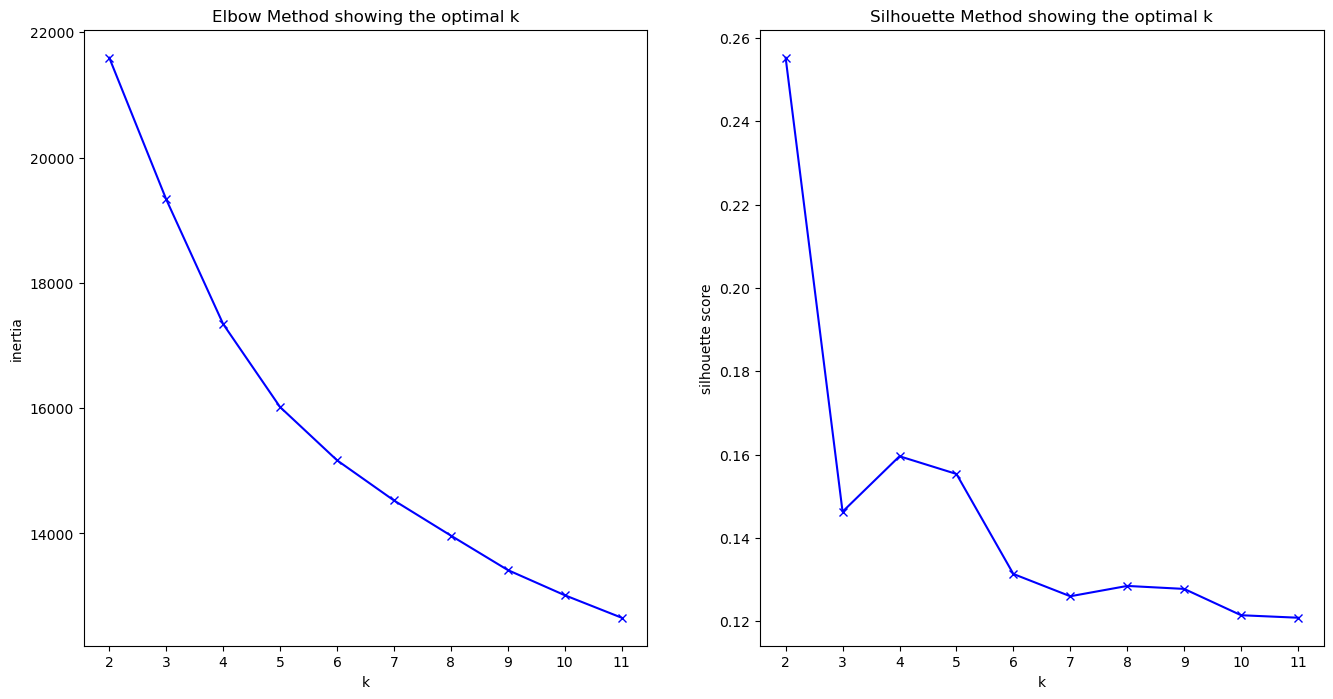

In [27]:
K = range(2, 12)

inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                    verbose=1)
    kmeans.fit(X_scaled_df)

    filename = "kmeans_" + str(k) + ".pickle" # Path with filename # kmeans_n.pickle
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)

    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

No visible elbow, Silhouette method isn't conclusive, too (low range of values) - checking K-Means on dimensionally reduced data

### Kmeans with ISOMAP

In [28]:
kmeans = KMeans(n_clusters=7, random_state=1234)
kmeans.fit(X_isomap_transformed_df)

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=7, random_state=1234)

In [29]:
clusters = kmeans.predict(X_isomap_transformed_df)
pd.Series(clusters).value_counts().sort_index() 

0    103
1    446
2    497
3    519
4    374
5    314
6    337
Name: count, dtype: int64

The songs in each cluster look mostly evenly distributed

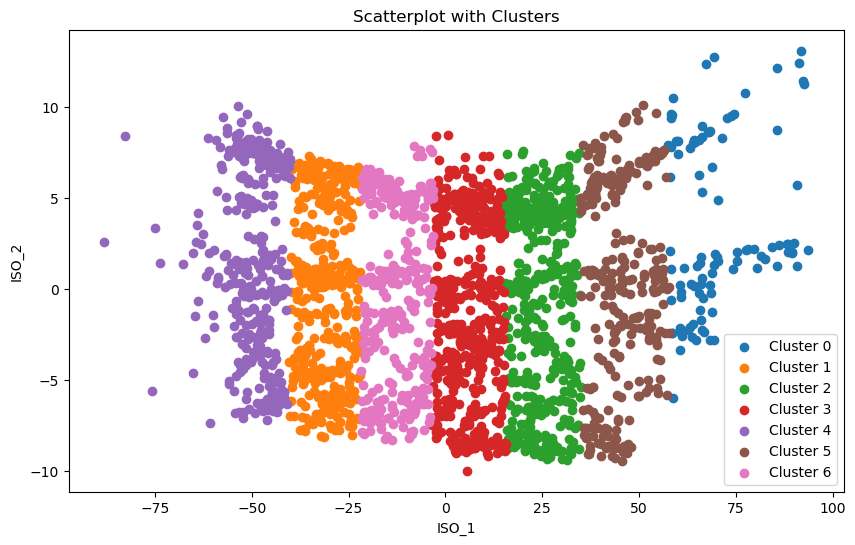

In [30]:
import matplotlib.pyplot as plt

X_isomap_transformed_df['KM_Cluster'] = clusters


plt.figure(figsize=(10, 6))
for cluster in range(7):
    cluster_data = X_isomap_transformed_df[X_isomap_transformed_df['KM_Cluster'] == cluster]
    plt.scatter(cluster_data['ISO_1'], cluster_data['ISO_2'], label=f'Cluster {cluster}')

plt.xlabel('ISO_1')
plt.ylabel('ISO_2')
plt.title('Scatterplot with Clusters')
plt.legend()
plt.show()

Clusters are divided pretty neatly, there is some minor spillover from one into the next one, eg red into green. Not the best clustering model.

### Kmeans with UMAP

In [31]:
kmeans = KMeans(n_clusters=7, random_state=1234)
kmeans.fit(X_umap_transformed_df)

filename = "kmeans_7_umap.pickle" # Path with filename # kmeans_n.pickle
with open(filename, "wb") as file:
    pickle.dump(kmeans,file)

/Users/noelia.escobar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [32]:
clusters = kmeans.predict(X_umap_transformed_df)
pd.Series(clusters).value_counts().sort_index() 

0    377
1    462
2    381
3    316
4    290
5    442
6    322
Name: count, dtype: int64

This dimensionality reduction looks the most evenly distributed

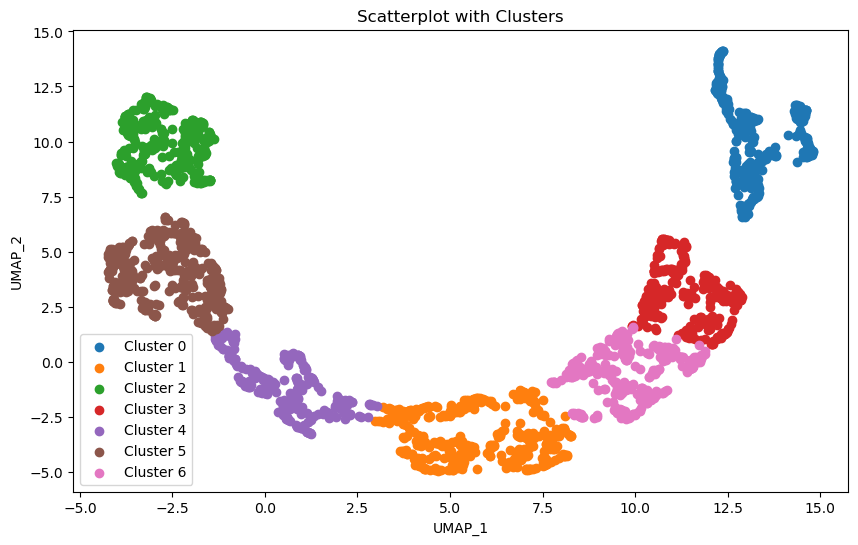

In [33]:
import matplotlib.pyplot as plt

X_umap_transformed_df['KM_Cluster'] = clusters


plt.figure(figsize=(10, 6))
for cluster in range(7):
    cluster_data = X_umap_transformed_df[X_umap_transformed_df['KM_Cluster'] == cluster]
    plt.scatter(cluster_data['UMAP_1'], cluster_data['UMAP_2'], label=f'Cluster {cluster}')

plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.title('Scatterplot with Clusters')
plt.legend()
plt.show()

In [34]:
kmeans.inertia_

7208.611328125

Lowest inertia value, best even distribution, 
#### this is the best clustering model!

Checking other combinations:

### DBSCAN with UMAP


In [35]:
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import time
import pickle

In [36]:
# Scaling features
scaler = StandardScaler()
scaler.fit(X_umap_transformed_df)
X_scaled_umap_np = scaler.transform(X_umap_transformed_df)
X_scaled_umap_df = pd.DataFrame(X_scaled_umap_np, columns=X_umap_transformed_df.columns)

# Creating the clustering model
model = DBSCAN() # Default values are: eps=0.5, min_samples=5
# fit model and predict clusters
yhat = model.fit_predict(X_scaled_umap_df) # .fit(X_scaled_df)

In [37]:
print("The Silhouette score of the model is: ",round(silhouette_score(X_scaled_umap_df, model.fit_predict(X_scaled_umap_df)),2))
print("The Calinksi-Harabasz score of the model is: ",round(calinski_harabasz_score(X_scaled_umap_df, model.fit_predict(X_scaled_umap_df)),2))

The Silhouette score of the model is:  0.74
The Calinksi-Harabasz score of the model is:  7770.14


In [38]:
X_umap_transformed_df['dbscan_clusters'] = yhat
X_umap_transformed_df.head()

,UMAP_1,UMAP_2,KM_Cluster,dbscan_clusters
0,-3.156207,11.865191,2,0
1,7.525872,-4.274052,1,1
2,3.637302,-2.566351,1,1
3,0.853498,-1.259137,4,2
4,9.751296,0.061032,6,3


In [39]:
# retrieve unique clusters
umap_db_clusters = np.unique(yhat)
umap_db_clusters # DBSCAN flags with "-1" noisy data.

array([0, 1, 2, 3, 4, 5])

No noise, 7 clusters like K-Means

In [40]:
[cluster for cluster in list(umap_db_clusters) if cluster != -1]

[0, 1, 2, 3, 4, 5]

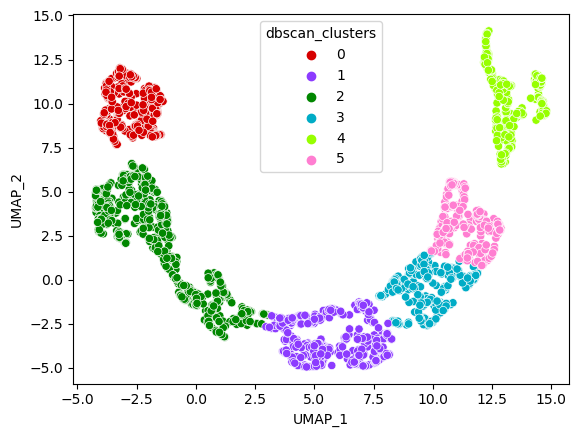

In [41]:
custom_palette = sns.color_palette(cc.glasbey, n_colors=umap_db_clusters.size)
# Modifiying the palette to set the color "black=(0.,0.,0.)" to the label "-1" #(R,G,B)
custom_palette = [color if cluster != -1 else (0.,0.,0.) for cluster, color in zip(umap_db_clusters,custom_palette)]
sns.scatterplot(X_umap_transformed_df, x="UMAP_1", y="UMAP_2", hue="dbscan_clusters", palette=custom_palette);
plt.show()

DBSCAN on default parameters with UMAP looks identical to KMeans with UMAP transformed data.

### DBSCAN with ISOMAP

In [42]:
# Scaling features
scaler = StandardScaler()
scaler.fit(X_isomap_transformed_df)
X_scaled_iso_np = scaler.transform(X_isomap_transformed_df)
X_scaled_iso_df = pd.DataFrame(X_scaled_iso_np, columns=X_isomap_transformed_df.columns)

# Creating the clustering model
model = DBSCAN() # Default values are: eps=0.5, min_samples=5
# fit model and predict clusters
yhat_iso = model.fit_predict(X_scaled_iso_df) # .fit(X_scaled_df)

In [43]:
print("The Silhouette score of the model is: ",round(silhouette_score(X_scaled_iso_df, model.fit_predict(X_scaled_iso_df)),2))
print("The Calinksi-Harabasz score of the model is: ",round(calinski_harabasz_score(X_scaled_iso_df, model.fit_predict(X_scaled_iso_df)),2))

The Silhouette score of the model is:  0.36
The Calinksi-Harabasz score of the model is:  690.63


In [42]:
X_isomap_transformed_df['dbscan_clusters'] = yhat_iso
X_isomap_transformed_df.head()

,ISO_1,ISO_2,KM_Cluster,dbscan_clusters
0,-61.046088,0.995589,4,0
1,7.564637,-3.056384,3,1
2,-2.460613,3.817904,3,1
3,-16.760730,4.512814,6,2
4,20.801687,6.494922,2,3


In [43]:
# retrieve unique clusters
iso_db_clusters = np.unique(yhat_iso)
iso_db_clusters # DBSCAN flags with "-1" noisy data.

array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64)

In [44]:
[cluster for cluster in list(iso_db_clusters) if cluster != -1]

[0, 1, 2, 3, 4, 5, 6, 7]

Here we have noisy data, and 1 additional cluster.

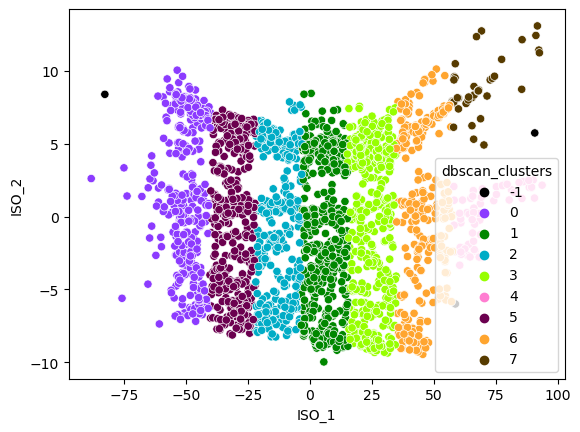

In [50]:
custom_palette = sns.color_palette(cc.glasbey, n_colors=iso_db_clusters.size)
# Modifiying the palette to set the color "black=(0.,0.,0.)" to the label "-1" #(R,G,B)
custom_palette = [color if cluster != -1 else (0.,0.,0.) for cluster, color in zip(iso_db_clusters,custom_palette)]
sns.scatterplot(X_isomap_transformed_df, x="ISO_1", y="ISO_2", hue="dbscan_clusters", palette=custom_palette);
plt.show()

Also here the situation looks identical to K-Means clustering --> noisier and messier than UMAP transformed data.

### HDBSCAN with ISOMAP

In [51]:
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [52]:
# Scaling features
scaler = StandardScaler()
scaler.fit(X_isomap_transformed_df)
X_scaled_iso_np = scaler.transform(X_isomap_transformed_df)
X_scaled_iso_df = pd.DataFrame(X_scaled_iso_np, columns=X_isomap_transformed_df.columns)

# Creating the clustering model
model = HDBSCAN() # Default values are: eps=0.5, min_samples=5
# fit model and predict clusters
yhat_iso_hdb = model.fit_predict(X_scaled_iso_df) # .fit(X_scaled_df)

In [53]:
print("The Silhouette score of the model is: ",round(silhouette_score(X_scaled_iso_df, model.fit_predict(X_scaled_iso_df)),2))
print("The Calinksi-Harabasz score of the model is: ",round(calinski_harabasz_score(X_scaled_iso_df, model.fit_predict(X_scaled_iso_df)),2))

The Silhouette score of the model is:  0.36
The Calinksi-Harabasz score of the model is:  332.36


In [54]:
X_isomap_transformed_df['hdbscan_clusters'] = yhat_iso_hdb
X_isomap_transformed_df.head()

,ISO_1,ISO_2,KM_Cluster,dbscan_clusters,hdbscan_clusters
0,-61.046088,0.995589,4,0,13
1,7.564637,-3.056384,3,1,4
2,-2.460613,3.817904,3,1,4
3,-16.760730,4.512814,6,2,-1
4,20.801687,6.494922,2,3,5


In [55]:
# retrieve unique clusters
clusters_iso_hdb = np.unique(yhat_iso_hdb)
clusters_iso_hdb # DBSCAN flags with "-1" noisy data.

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
      dtype=int64)

In [56]:
[cluster for cluster in list(clusters_iso_hdb) if cluster != -1]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [58]:
clusters_iso_hdb.size - 1

31

too many clusters!

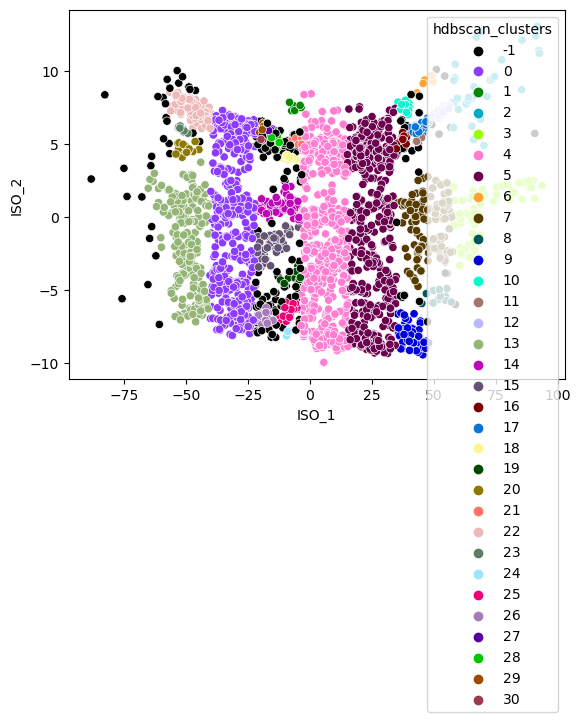

In [59]:
custom_palette = sns.color_palette(cc.glasbey, n_colors=clusters_iso_hdb.size)
# Modifiying the palette to set the color "black=(0.,0.,0.)" to the label "-1"
custom_palette = [color if cluster != -1 else (0.,0.,0.) for cluster, color in zip(clusters_iso_hdb,custom_palette)]
sns.scatterplot(X_isomap_transformed_df, x="ISO_1", y="ISO_2", hue="hdbscan_clusters", palette=custom_palette);
plt.show()

messiest cluster model so far

### HDBSCAN with UMAP

In [60]:
# Scaling features
scaler = StandardScaler()
scaler.fit(X_umap_transformed_df)
X_scaled_umap_np = scaler.transform(X_umap_transformed_df)
X_scaled_umap_df = pd.DataFrame(X_scaled_umap_np, columns=X_umap_transformed_df.columns)

# Creating the clustering model
model = HDBSCAN() # Default values are: eps=0.5, min_samples=5
# fit model and predict clusters
yhat_umap_hdb = model.fit_predict(X_scaled_umap_df) # .fit(X_scaled_df)

In [61]:
print("The Silhouette score of the model is: ",round(silhouette_score(X_scaled_umap_df, model.fit_predict(X_scaled_umap_df)),2))
print("The Calinksi-Harabasz score of the model is: ",round(calinski_harabasz_score(X_scaled_umap_df, model.fit_predict(X_scaled_umap_df)),2))

The Silhouette score of the model is:  0.26
The Calinksi-Harabasz score of the model is:  51.82


In [63]:
X_umap_transformed_df['hdbscan_clusters'] = yhat_umap_hdb
X_umap_transformed_df.head()

,UMAP_1,UMAP_2,KM_Cluster,dbscan_clusters,hdbscan_clusters
0,-4.358989,11.873200,0,0,38
1,7.641131,-3.449520,4,1,-1
2,3.536043,-2.184105,4,1,50
3,-0.576040,-1.190000,2,2,8
4,9.672899,0.747108,1,3,122


In [65]:
# retrieve unique clusters
clusters_umap_hdb = np.unique(yhat_umap_hdb)
clusters_umap_hdb # DBSCAN flags with "-1" noisy data.

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165], dtype=int64)

even worse situation with too many clusters

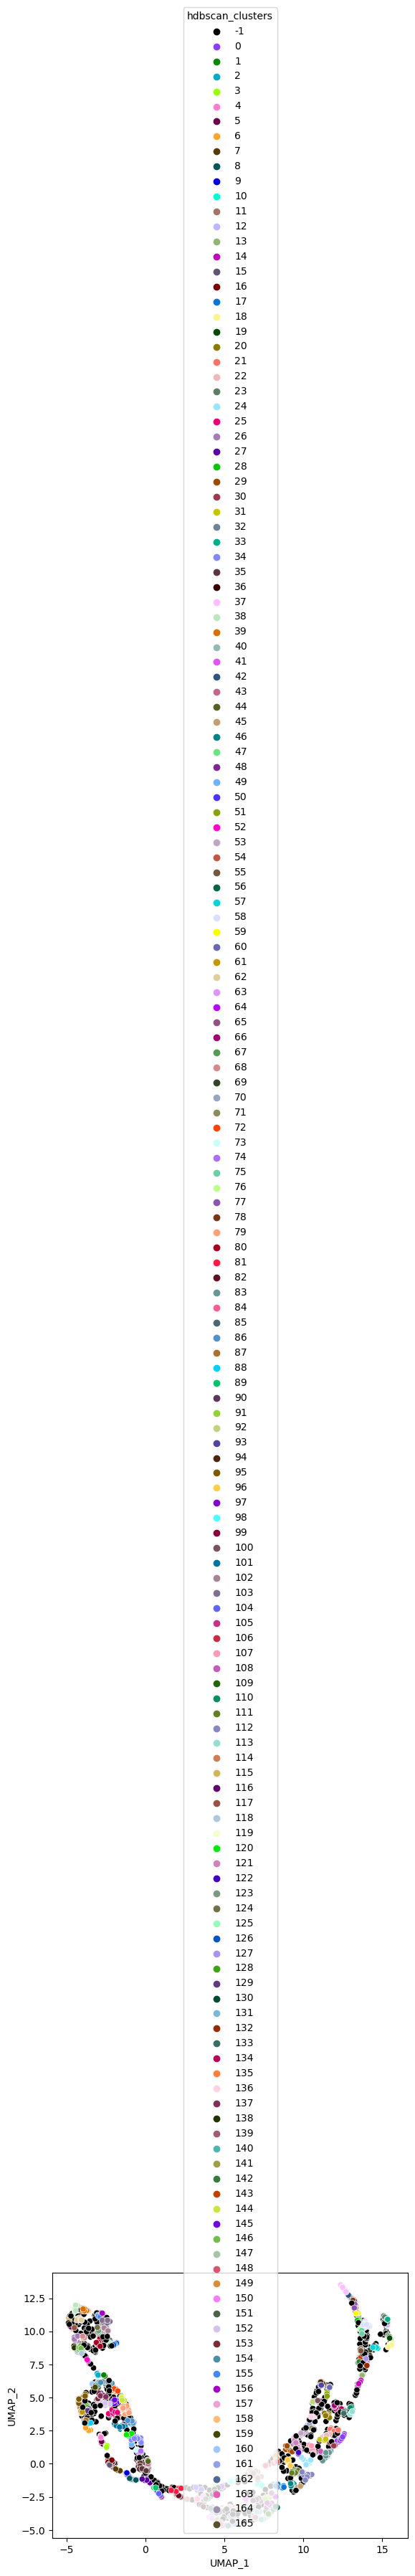

In [66]:
custom_palette = sns.color_palette(cc.glasbey, n_colors=clusters_umap_hdb.size)
# Modifiying the palette to set the color "black=(0.,0.,0.)" to the label "-1"
custom_palette = [color if cluster != -1 else (0.,0.,0.) for cluster, color in zip(clusters_umap_hdb,custom_palette)]
sns.scatterplot(X_umap_transformed_df, x="UMAP_1", y="UMAP_2", hue="hdbscan_clusters", palette=custom_palette);
plt.show()

looks horrible. Could probably get better with parameter tweaking, but it's not worth it, since K-Means provides neat clustering already.

In [69]:
#assigning the best clustering to the original dataframe

combined_data['cluster'] = X_umap_transformed_df['KM_Cluster']
combined_data

,Title,Artists,id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,hot_song,cluster
0,Rockin' Around The Christmas Tree,Brenda Lee,2EjXfH91m7f8HiJN1yQg97,0.589,0.472,8,-8.749,1,0.0502,0.61400,...,0.898,67.196,audio_features,spotify:track:2EjXfH91m7f8HiJN1yQg97,https://api.spotify.com/v1/tracks/2EjXfH91m7f8...,https://api.spotify.com/v1/audio-analysis/2EjX...,126267,4,1,0
1,All I Want For Christmas Is You,Mariah Carey,7iKRL1F3m4t4dkMponnD0P,0.548,0.871,7,-4.253,1,0.0708,0.00113,...,0.640,128.136,audio_features,spotify:track:7iKRL1F3m4t4dkMponnD0P,https://api.spotify.com/v1/tracks/7iKRL1F3m4t4...,https://api.spotify.com/v1/audio-analysis/7iKR...,215653,4,1,4
2,Jingle Bell Rock,Bobby Helms,7vQbuQcyTflfCIOu3Uzzya,0.754,0.424,2,-8.463,1,0.0363,0.64300,...,0.806,119.705,audio_features,spotify:track:7vQbuQcyTflfCIOu3Uzzya,https://api.spotify.com/v1/tracks/7vQbuQcyTflf...,https://api.spotify.com/v1/audio-analysis/7vQb...,130973,4,1,4
3,Last Christmas,Wham!,2FRnf9qhLbvw8fu4IBXx78,0.735,0.478,2,-12.472,1,0.0293,0.18900,...,0.947,107.682,audio_features,spotify:track:2FRnf9qhLbvw8fu4IBXx78,https://api.spotify.com/v1/tracks/2FRnf9qhLbvw...,https://api.spotify.com/v1/audio-analysis/2FRn...,262960,4,1,2
4,A Holly Jolly Christmas,Burl Ives,77khP2fIVhSW23NwxrRluh,0.683,0.375,0,-13.056,1,0.0303,0.57900,...,0.888,140.467,audio_features,spotify:track:77khP2fIVhSW23NwxrRluh,https://api.spotify.com/v1/tracks/77khP2fIVhSW...,https://api.spotify.com/v1/audio-analysis/77kh...,135533,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,Vette Motors,YoungBoy Never Broke Again,0HrWshW3SuFJ6nKS9ba9Mh,0.830,0.644,10,-5.431,0,0.4070,0.02980,...,0.227,155.103,audio_features,spotify:track:0HrWshW3SuFJ6nKS9ba9Mh,https://api.spotify.com/v1/tracks/0HrWshW3SuFJ...,https://api.spotify.com/v1/audio-analysis/0HrW...,173419,4,0,5
2586,Breaking Me,Topic,3H7ihDc1dqLriiWXwsc2po,0.789,0.720,8,-5.652,0,0.2180,0.22300,...,0.664,122.031,audio_features,spotify:track:3H7ihDc1dqLriiWXwsc2po,https://api.spotify.com/v1/tracks/3H7ihDc1dqLr...,https://api.spotify.com/v1/audio-analysis/3H7i...,166794,4,0,4
2587,Wanted,OneRepublic,3fT6xqEkC1jm4mHjOyXbKw,0.665,0.539,1,-6.613,1,0.0699,0.16500,...,0.666,145.828,audio_features,spotify:track:3fT6xqEkC1jm4mHjOyXbKw,https://api.spotify.com/v1/tracks/3fT6xqEkC1jm...,https://api.spotify.com/v1/audio-analysis/3fT6...,136248,4,0,5
2588,Con Tus Besos,Eslabon Armado,6WYB1odDfMPVMyp1QxFInT,0.681,0.664,6,-8.019,0,0.0353,0.33500,...,0.861,102.166,audio_features,spotify:track:6WYB1odDfMPVMyp1QxFInT,https://api.spotify.com/v1/tracks/6WYB1odDfMPV...,https://api.spotify.com/v1/audio-analysis/6WYB...,226821,3,0,6


In [70]:
combined_data.to_csv('combined_data_clusters.csv', index=False)